In [37]:
# Import Libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

Performing ETL

In [38]:
# Directories
general_directory = '/Users/sanidhyark/Desktop/Agtech/Stream_3_Final_assignment'
precip_directory = 'july_2023_precip_sum.csv'
rm_gis_directory = 'rm_geo_json.geojson'
rm_yields_directory='rm_yields_2004_2023_weighted_avg.csv'

In [39]:
# Loading datasets
df_precip = pd.read_csv(precip_directory)
df_yield = pd.read_csv(rm_yields_directory)
gdf_rm = gpd.read_file(rm_gis_directory)

Filtering for 2023 data and dropping field peas

In [40]:
# Filter the DataFrame for the year 2023 and exclude 'FIELD PEAS'
df_yield2023 = df_yield[(df_yield['Year'] == 2023) & (df_yield['Crop'] != 'FIELD PEAS')]

# Display the filtered DataFrame
print(df_yield2023)


      Matched_RM              Crop  Year  Weighted_Avg_Yield
19     ALEXANDER  ARGENTINE CANOLA  2023           59.500000
62     ALEXANDER  RED SPRING WHEAT  2023           84.200000
81        ALONSA  ARGENTINE CANOLA  2023           44.309160
94        ALONSA            BARLEY  2023           54.400000
128       ALONSA  RED SPRING WHEAT  2023           55.700000
...          ...               ...   ...                 ...
6642   WOODLANDS  RED SPRING WHEAT  2023           60.240055
6662  YELLOWHEAD  ARGENTINE CANOLA  2023           53.606940
6682  YELLOWHEAD            BARLEY  2023          101.974092
6719  YELLOWHEAD              OATS  2023          124.600000
6739  YELLOWHEAD  RED SPRING WHEAT  2023           72.598611

[286 rows x 4 columns]


Exploratory Data Analysis

Identifying number null values for crops. Inserting null values to idenitfy this. This value will show us how much more or less certain crops are cultivated in Manitoba RMs.

merged_df has NULL values added

In [41]:
# Define the crops to ensure they are included
required_crops = ['ARGENTINE CANOLA', 'RED SPRING WHEAT', 'BARLEY', 'OATS']

# Get unique Matched_RMs from the original DataFrame
matched_rms = df_yield2023['Matched_RM'].unique()

# Create a complete DataFrame with all combinations of Matched_RM and required crops
complete_data = {
    'Matched_RM': [],
    'Crop': [],
    'Year': [],
    'Weighted_Avg_Yield': []
}

for rm in matched_rms:
    for crop in required_crops:
        complete_data['Matched_RM'].append(rm)
        complete_data['Crop'].append(crop)
        complete_data['Year'].append(2023)
        complete_data['Weighted_Avg_Yield'].append(None)  # Initializing with None

complete_df = pd.DataFrame(complete_data)

# Now merge the original DataFrame with the complete DataFrame
merged_df = pd.merge(complete_df, df_yield2023, on=['Matched_RM', 'Crop', 'Year'], how='left', suffixes=('', '_orig'))

# Fill in Weighted_Avg_Yield from the original DataFrame where available
merged_df['Weighted_Avg_Yield'].fillna(merged_df['Weighted_Avg_Yield_orig'], inplace=True)

# Drop the original yield column
merged_df.drop(columns='Weighted_Avg_Yield_orig', inplace=True)

# Display the result
print(merged_df)

     Matched_RM              Crop  Year  Weighted_Avg_Yield
0     ALEXANDER  ARGENTINE CANOLA  2023           59.500000
1     ALEXANDER  RED SPRING WHEAT  2023           84.200000
2     ALEXANDER            BARLEY  2023                 NaN
3     ALEXANDER              OATS  2023                 NaN
4        ALONSA  ARGENTINE CANOLA  2023           44.309160
..          ...               ...   ...                 ...
355   WOODLANDS              OATS  2023          101.638731
356  YELLOWHEAD  ARGENTINE CANOLA  2023           53.606940
357  YELLOWHEAD  RED SPRING WHEAT  2023           72.598611
358  YELLOWHEAD            BARLEY  2023          101.974092
359  YELLOWHEAD              OATS  2023          124.600000

[360 rows x 4 columns]


/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_75285/1493212017.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Weighted_Avg_Yield'].fillna(merged_df['Weighted_Avg_Yield_orig'], inplace=True)
/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_75285/1493212017.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('fut

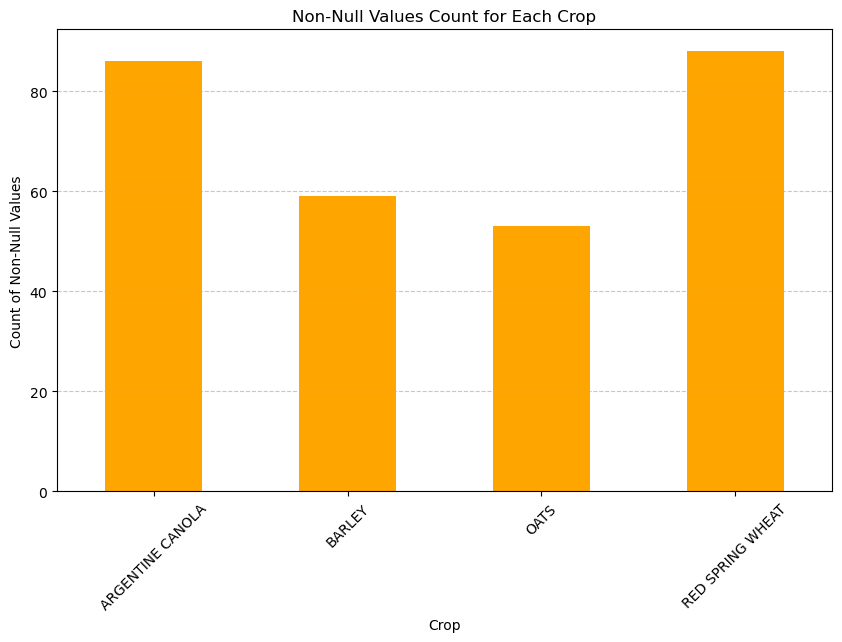

In [43]:
# Count non-null values for each crop
non_null_counts2 = merged_df.groupby('Crop')['Weighted_Avg_Yield'].count()

# Plotting
plt.figure(figsize=(10, 6))
non_null_counts2.plot(kind='bar', color='orange')
plt.title('Non-Null Values Count for Each Crop')
plt.xlabel('Crop')
plt.ylabel('Count of Non-Null Values')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

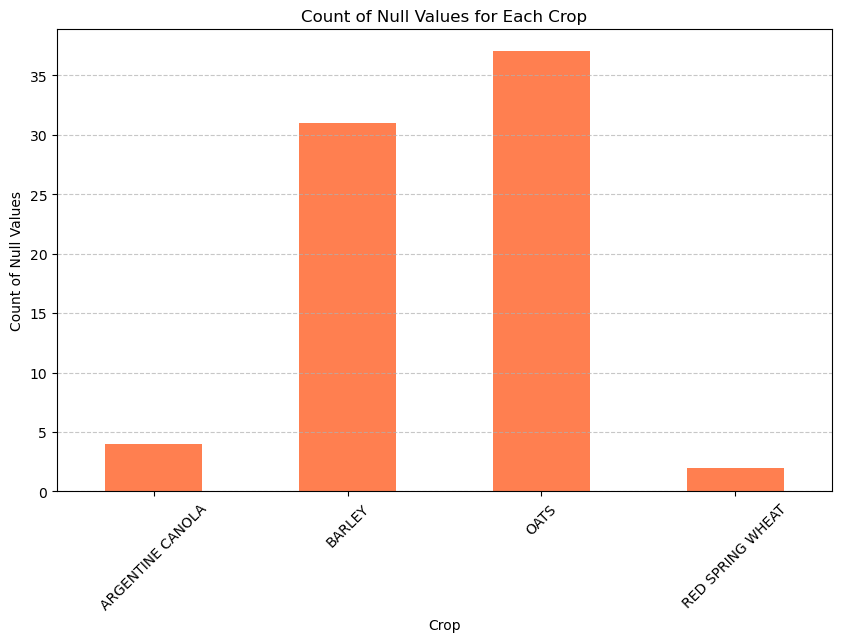

In [44]:
# Count null values for each crop
null_counts = merged_df.groupby('Crop')['Weighted_Avg_Yield'].apply(lambda x: x.isnull().sum())

# Plotting the null values count
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color='coral')
plt.title('Count of Null Values for Each Crop')
plt.xlabel('Crop')
plt.ylabel('Count of Null Values')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Starting feature engineering - Mean and STD (No individual crop column now)

In [45]:
# Finding mean and std for each rm for Feature Engineering and resetting index
df_yield_agg = df_yield2023.groupby('Matched_RM')['Weighted_Avg_Yield'].agg(['mean', 'std']).reset_index()

# Renaming Columns
df_yield_agg.columns=['_'.join(col).strip() for col in df_yield_agg.columns]

# Resetting index
df_yield2023final=df_yield_agg.reset_index()


In [46]:
print(df_yield2023final.columns)

Index(['index', 'M_a_t_c_h_e_d___R_M', 'm_e_a_n', 's_t_d'], dtype='object')


In [47]:
# Renaming columns
df_yield2023final.rename(columns={
    'M_a_t_c_h_e_d___R_M': 'Matched_RM',
    'm_e_a_n': 'Mean_Yield',
    's_t_d': 'Standard_Deviation'
}, inplace=True)

# Display the updated DataFrame
print(df_yield2023final)

    index        Matched_RM  Mean_Yield  Standard_Deviation
0       0         ALEXANDER   71.850000           17.465537
1       1            ALONSA   51.469720            6.235200
2       2            ARGYLE   71.540275           26.551788
3       3         ARMSTRONG   76.931521           43.319512
4       4  BIFROST-RIVERTON   75.345433           34.599096
..    ...               ...         ...                 ...
85     85         WHITEHEAD   69.373609           26.015255
86     86        WHITEMOUTH   52.126038                 NaN
87     87          WINNIPEG   58.048647            7.564130
88     88         WOODLANDS   74.964477           23.865648
89     89        YELLOWHEAD   88.194911           31.383481

[90 rows x 4 columns]


Some more Data quality check and cleaning


In [48]:
print(df_yield2023final.columns)


Index(['index', 'Matched_RM', 'Mean_Yield', 'Standard_Deviation'], dtype='object')


In [49]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count the null values
null_counts = df_yield2023final.isnull().sum()
print(null_counts)


index                 0
Matched_RM            0
Mean_Yield            0
Standard_Deviation    4
dtype: int64


In [51]:
# Count the non-null values
not_null_counts = df_yield2023final.notnull().sum()
print(not_null_counts)


index                 90
Matched_RM            90
Mean_Yield            90
Standard_Deviation    86
dtype: int64


The reason we have 4 null values for standard deviation is coz some RMs have grown only 1 crop in 2023


Replacing null values in std with 0 as it has no impact on the data

In [52]:
# Assuming your DataFrame is named df_yield_agg
df_yield2023final['Standard_Deviation'].fillna(0, inplace=True)


/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_75285/3775716365.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_yield2023final['Standard_Deviation'].fillna(0, inplace=True)


In [53]:
#COunting again to make sure 
null_value_check = df_yield2023final.isnull().sum()
print(null_value_check)

index                 0
Matched_RM            0
Mean_Yield            0
Standard_Deviation    0
dtype: int64


In [54]:
print(df_yield2023final)

    index        Matched_RM  Mean_Yield  Standard_Deviation
0       0         ALEXANDER   71.850000           17.465537
1       1            ALONSA   51.469720            6.235200
2       2            ARGYLE   71.540275           26.551788
3       3         ARMSTRONG   76.931521           43.319512
4       4  BIFROST-RIVERTON   75.345433           34.599096
..    ...               ...         ...                 ...
85     85         WHITEHEAD   69.373609           26.015255
86     86        WHITEMOUTH   52.126038            0.000000
87     87          WINNIPEG   58.048647            7.564130
88     88         WOODLANDS   74.964477           23.865648
89     89        YELLOWHEAD   88.194911           31.383481

[90 rows x 4 columns]


In [55]:
print(df_precip)

           Matched_RM   Period  Year     precip
0         SPRINGFIELD  Jul2023  2023  52.032609
1              ARGYLE  Jul2023  2023  27.387097
2              ROLAND  Jul2023  2023  33.100000
3            MONTCALM  Jul2023  2023  53.628571
4            MOUNTAIN  Jul2023  2023  28.907489
..                ...      ...   ...        ...
88         YELLOWHEAD  Jul2023  2023  26.202381
89       MINTO-ODANAH  Jul2023  2023  25.758065
90      NORTH NORFOLK  Jul2023  2023  21.617021
91  RUSSELL-BINSCARTH  Jul2023  2023  41.306122
92       MOSSEY RIVER  Jul2023  2023  34.131868

[93 rows x 4 columns]


In [56]:
#Checking for null values

null_counts3 = df_precip.isnull().sum()
print(null_counts3)


Matched_RM    0
Period        0
Year          0
precip        0
dtype: int64


In [57]:
# Rename 'precip' to 'Precipitation' and drop 'Period' column
df_precipfinal = df_precip.rename(columns={'precip': 'Precipitation'}).drop(columns='Period')

print(df_precipfinal)

           Matched_RM  Year  Precipitation
0         SPRINGFIELD  2023      52.032609
1              ARGYLE  2023      27.387097
2              ROLAND  2023      33.100000
3            MONTCALM  2023      53.628571
4            MOUNTAIN  2023      28.907489
..                ...   ...            ...
88         YELLOWHEAD  2023      26.202381
89       MINTO-ODANAH  2023      25.758065
90      NORTH NORFOLK  2023      21.617021
91  RUSSELL-BINSCARTH  2023      41.306122
92       MOSSEY RIVER  2023      34.131868

[93 rows x 3 columns]


In [58]:
pip install mplcursors --upgrade


Note: you may need to restart the kernel to use updated packages.


In [59]:
import mplcursors

In [60]:
print(geo_merged1_df.isnull().sum())


Matched_RM            0
geometry              0
index                 5
Mean_Yield            5
Standard_Deviation    5
Year                  5
Precipitation         5
dtype: int64


In [61]:
geo_merged1_df = geo_merged1_df.dropna()


In [62]:
print(geo_merged1_df.head())

    Matched_RM                                           geometry  index  \
0  SPRINGFIELD  POLYGON ((-96.63590 50.05916, -96.63598 50.054...   70.0   
1       ARGYLE  POLYGON ((-99.36013 49.53290, -99.35971 49.532...    2.0   
2       ROLAND  POLYGON ((-97.73079 49.44360, -97.73077 49.436...   63.0   
3     MONTCALM  POLYGON ((-97.35109 49.35454, -97.34910 49.354...   43.0   
4     MOUNTAIN  MULTIPOLYGON (((-100.73892 52.23090, -100.7270...   46.0   

   Mean_Yield  Standard_Deviation    Year  Precipitation  
0   95.542993           43.369328  2023.0      52.032609  
1   71.540275           26.551788  2023.0      27.387097  
2   58.185504           16.156028  2023.0      33.100000  
3   67.379233           21.011958  2023.0      53.628571  
4   56.845555            6.774125  2023.0      28.907489  


In [63]:
import matplotlib
matplotlib.use('TkAgg')  # or 'Qt5Agg', depending on what's available


In [64]:
%matplotlib inline



Plotting Precipitation data and Mean average yield side by side to make comparison

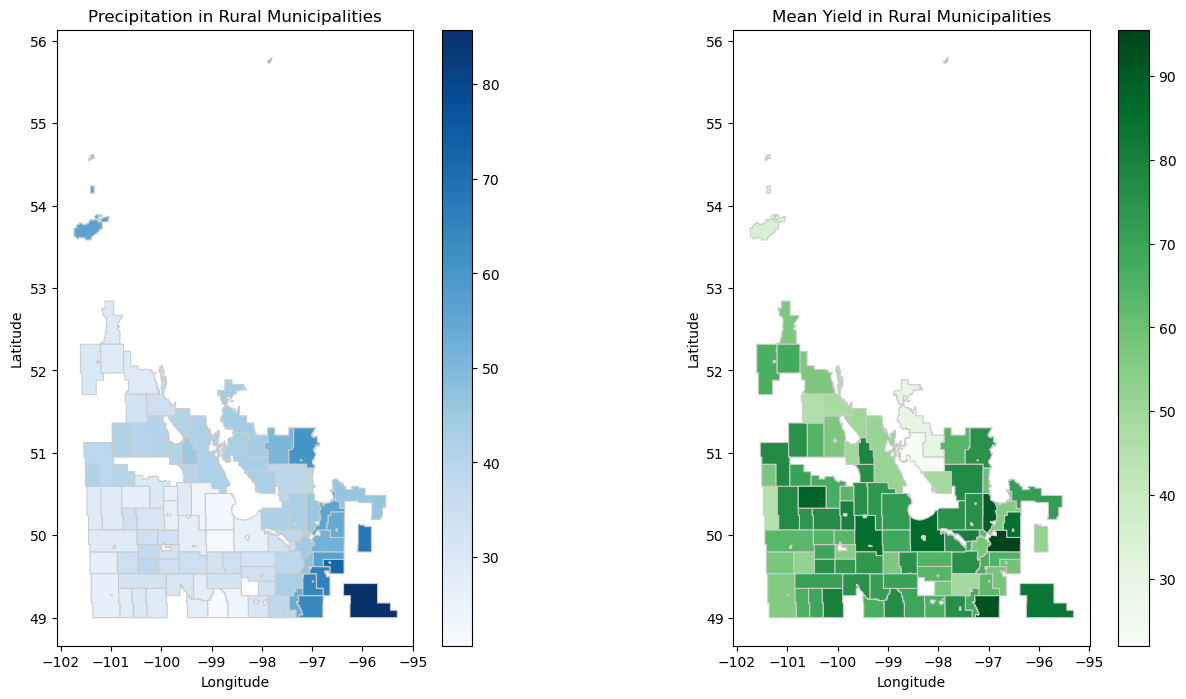

In [66]:
# Merge yield and precipitation data on 'Matched_RM'
new1_df = pd.merge(df_yield2023final, df_precipfinal, on='Matched_RM', how='inner')

# Merge with the GeoDataFrame
geo_merged1_df = gdf_rm.merge(new1_df, on='Matched_RM', how='left')

# Set up side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot for Precipitation
p_plot = geo_merged1_df.plot(column='Precipitation', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='0.8', legend=True)
ax1.set_title('Precipitation in Rural Municipalities')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Add dynamic cursor for Precipitation plot
mplcursors.cursor(p_plot, hover=True).connect("add", lambda sel: sel.annotation.set_text(geo_merged1_df['Matched_RM'].iloc[sel.index]))

# Plot for Mean Yield
y_plot = geo_merged1_df.plot(column='Mean_Yield', cmap='Greens', linewidth=0.8, ax=ax2, edgecolor='0.8', legend=True)
ax2.set_title('Mean Yield in Rural Municipalities')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

# Add dynamic cursor for Yield plot
mplcursors.cursor(y_plot, hover=True).connect("add", lambda sel: sel.annotation.set_text(geo_merged1_df['Matched_RM'].iloc[sel.index]))

# Adding Annotations using Centroids
for idx, row in geo_merged1_df.iterrows():
    # Get centroid coordinates
    centroid = row.geometry.centroid
    ax.annotate(row['Matched_RM'], xy=(centroid.x, centroid.y), fontsize=8, ha='center')

plt.show()



In [36]:
# After plotting the map
mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(geo_merged1_df['Matched_RM'].iloc[sel.index]))

<function __main__.<lambda>(sel)>

Merging the two plots to show relative yield to precipitation

Correlation between Mean Yield and Precipitation: -0.06171394780679682


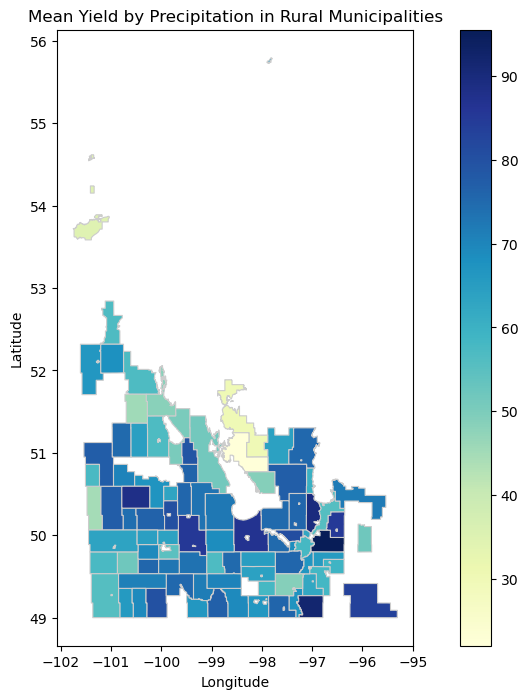

In [67]:

# Merge yield and precipitation data on 'Matched_RM'
mix_df = pd.merge(df_yield2023final, df_precipfinal, on='Matched_RM', how='inner')

# Calculate the correlation between Mean_Yield and Precipitation
correlation_value = mix_df[['Mean_Yield', 'Precipitation']].corr().iloc[0, 1]
print(f"Correlation between Mean Yield and Precipitation: {correlation_value}")

# Merge with the GeoDataFrame
geo_mix_df = gdf_rm.merge(mix_df, on='Matched_RM', how='left')

# Plot the Mean Yield with precipitation on the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mean_yield_plot = geo_mix_df.plot(column='Mean_Yield', cmap='YlGnBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add dynamic cursor for the plot
mplcursors.cursor(mean_yield_plot, hover=True).connect("add", lambda sel: sel.annotation.set_text(geo_mix_df['Matched_RM'].iloc[sel.index]))

plt.title('Mean Yield by Precipitation in Rural Municipalities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [30]:

combined_df = df_precipfinal.merge(df_yield2023final, on='Matched_RM', how='inner')

# Selecting only the columns of interest
new2_df = combined_df[['Matched_RM', 'Precipitation', 'Mean_Yield', 'Standard_Deviation']]

# Display the merged DataFrame
print(new2_df)

           Matched_RM  Precipitation  Mean_Yield  Standard_Deviation
0         SPRINGFIELD      52.032609   95.542993           43.369328
1              ARGYLE      27.387097   71.540275           26.551788
2              ROLAND      33.100000   58.185504           16.156028
3            MONTCALM      53.628571   67.379233           21.011958
4            MOUNTAIN      28.907489   56.845555            6.774125
..                ...            ...         ...                 ...
84         YELLOWHEAD      26.202381   88.194911           31.383481
85       MINTO-ODANAH      25.758065   80.260314           30.292349
86      NORTH NORFOLK      21.617021   68.615924           21.612374
87  RUSSELL-BINSCARTH      41.306122   57.358921            9.344523
88       MOSSEY RIVER      34.131868   48.255130           18.060296

[89 rows x 4 columns]


#Creating TOPSIS score for all crops and for the above plot and ranking them. This will show us the names of the regions that have the highest correlation between yield and precipitation. 

I tried using Dynamic cursors on my plots to show the names of the regions but for some reason it doesnt work on my environment. The code for that has executed without errors though, so I'm not sure whats the problem. I've left the dynamic curson code in still. 

In [121]:
#Importing Numpy
import numpy as np

In [99]:
# Step 1: Normalize the data
normalized_df = new2_df[['Precipitation', 'Mean_Yield', 'Standard_Deviation']].copy()

# For maximization, we can use the formula: 
# normalized_value = value / sqrt(sum(value^2))
for col in normalized_df.columns:
    normalized_df[col] = normalized_df[col] / np.sqrt(np.sum(normalized_df[col] ** 2))

# Step 2: Define the ideal (best) and negative-ideal (worst) solutions
ideal_solution = normalized_df.max()
negative_ideal_solution = normalized_df.min()

# Step 3: Calculate the distance to the ideal and negative-ideal solutions
distance_to_ideal = np.sqrt(((normalized_df - ideal_solution) ** 2).sum(axis=1))
distance_to_negative_ideal = np.sqrt(((normalized_df - negative_ideal_solution) ** 2).sum(axis=1))

# Step 4: Calculate the TOPSIS score
topsis_score = distance_to_negative_ideal / (distance_to_ideal + distance_to_negative_ideal)

# Step 5: Add scores to the DataFrame
new2_df['TOPSIS_Score'] = topsis_score

# Step 6: Sort by TOPSIS score and create a rank column
df_topsis_sorted = new2_df.sort_values(by='TOPSIS_Score', ascending=False)
df_topsis_sorted['Rank'] = df_topsis_sorted['TOPSIS_Score'].rank(ascending=False)

# Step 7: Display the ranked DataFrame
print(df_topsis_sorted[['Matched_RM', 'TOPSIS_Score', 'Rank']])




          Matched_RM  TOPSIS_Score  Rank
31             PINEY      0.940139   1.0
68  EMERSON-FRANKLIN      0.724303   2.0
0        SPRINGFIELD      0.719006   3.0
36  BIFROST-RIVERTON      0.666023   4.0
19       ST. ANDREWS      0.640955   5.0
..               ...           ...   ...
7           COLDWELL      0.215114  85.0
4           MOUNTAIN      0.206942  86.0
21     ELLICE-ARCHIE      0.192006  87.0
79    WEST INTERLAKE      0.173886  88.0
59         ETHELBERT      0.162623  89.0

[89 rows x 3 columns]


/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_75285/2963512682.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new2_df['TOPSIS_Score'] = topsis_score


In [101]:
# Viewing all columns
pd.set_option('display.max_columns', None)
print(df_topsis_sorted)

# Exporting to CSV
df_topsis_sorted.to_csv('topsis_scores.csv', index=False)

          Matched_RM  Precipitation  Mean_Yield  Standard_Deviation  \
31             PINEY      85.780220   83.380179           50.499189   
68  EMERSON-FRANKLIN      64.000000   91.986010           36.154726   
0        SPRINGFIELD      52.032609   95.542993           43.369328   
36  BIFROST-RIVERTON      60.325758   75.345433           34.599096   
19       ST. ANDREWS      45.590164   89.615286           38.344442   
..               ...            ...         ...                 ...   
7           COLDWELL      42.973333   48.800000            0.000000   
4           MOUNTAIN      28.907489   56.845555            6.774125   
21     ELLICE-ARCHIE      28.927711   44.919957            9.365299   
79    WEST INTERLAKE      42.924658   22.000000            0.000000   
59         ETHELBERT      32.829545   45.455812            3.544685   

    TOPSIS_Score  Rank  
31      0.940139   1.0  
68      0.724303   2.0  
0       0.719006   3.0  
36      0.666023   4.0  
19      0.640955   5.0

In [33]:
print(gdf_rm)

           Matched_RM                                           geometry
0         SPRINGFIELD  POLYGON ((-96.63590 50.05916, -96.63598 50.054...
1              ARGYLE  POLYGON ((-99.36013 49.53290, -99.35971 49.532...
2              ROLAND  POLYGON ((-97.73079 49.44360, -97.73077 49.436...
3            MONTCALM  POLYGON ((-97.35109 49.35454, -97.34910 49.354...
4            MOUNTAIN  MULTIPOLYGON (((-100.73892 52.23090, -100.7270...
..                ...                                                ...
89         YELLOWHEAD  POLYGON ((-100.77337 50.59426, -100.76226 50.5...
90       MINTO-ODANAH  POLYGON ((-99.94217 50.41731, -99.93083 50.417...
91      NORTH NORFOLK  POLYGON ((-98.56019 50.06348, -98.56024 50.056...
92  RUSSELL-BINSCARTH  POLYGON ((-101.49739 50.85971, -101.48620 50.8...
93       MOSSEY RIVER  POLYGON ((-99.98127 52.05782, -99.98092 52.057...

[94 rows x 2 columns]


In [68]:
print(df_yield2023)

      Matched_RM              Crop  Year  Weighted_Avg_Yield
19     ALEXANDER  ARGENTINE CANOLA  2023           59.500000
62     ALEXANDER  RED SPRING WHEAT  2023           84.200000
81        ALONSA  ARGENTINE CANOLA  2023           44.309160
94        ALONSA            BARLEY  2023           54.400000
128       ALONSA  RED SPRING WHEAT  2023           55.700000
...          ...               ...   ...                 ...
6642   WOODLANDS  RED SPRING WHEAT  2023           60.240055
6662  YELLOWHEAD  ARGENTINE CANOLA  2023           53.606940
6682  YELLOWHEAD            BARLEY  2023          101.974092
6719  YELLOWHEAD              OATS  2023          124.600000
6739  YELLOWHEAD  RED SPRING WHEAT  2023           72.598611

[286 rows x 4 columns]


In [69]:
print(df_precipfinal)

           Matched_RM  Year  Precipitation
0         SPRINGFIELD  2023      52.032609
1              ARGYLE  2023      27.387097
2              ROLAND  2023      33.100000
3            MONTCALM  2023      53.628571
4            MOUNTAIN  2023      28.907489
..                ...   ...            ...
88         YELLOWHEAD  2023      26.202381
89       MINTO-ODANAH  2023      25.758065
90      NORTH NORFOLK  2023      21.617021
91  RUSSELL-BINSCARTH  2023      41.306122
92       MOSSEY RIVER  2023      34.131868

[93 rows x 3 columns]


Spectral clustering for wheat

In [70]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.cluster import SpectralClustering

# Filter for wheat data and cluster
df_wheat = df_yield2023[df_yield2023['Crop'] == 'RED SPRING WHEAT']
X = df_wheat[['Weighted_Avg_Yield']].copy()
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
df_wheat['Cluster'] = spectral.fit_predict(X)


/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_75285/2395282128.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wheat['Cluster'] = spectral.fit_predict(X)


In [71]:
# Merge wheat data with precipitation
df_merged = df_wheat[['Matched_RM', 'Weighted_Avg_Yield', 'Cluster']].merge(
    df_precipfinal[['Matched_RM', 'Precipitation']], on='Matched_RM', how='inner'
)

In [72]:
# Load geospatial data for plotting (assuming gdf_rm contains geometries for Matched_RM)
gdf_wheat_clusters = gdf_rm.merge(df_merged[['Matched_RM', 'Cluster']], on='Matched_RM', how='left')
gdf_precip = gdf_rm.merge(df_precipfinal[['Matched_RM', 'Precipitation']], on='Matched_RM', how='left')

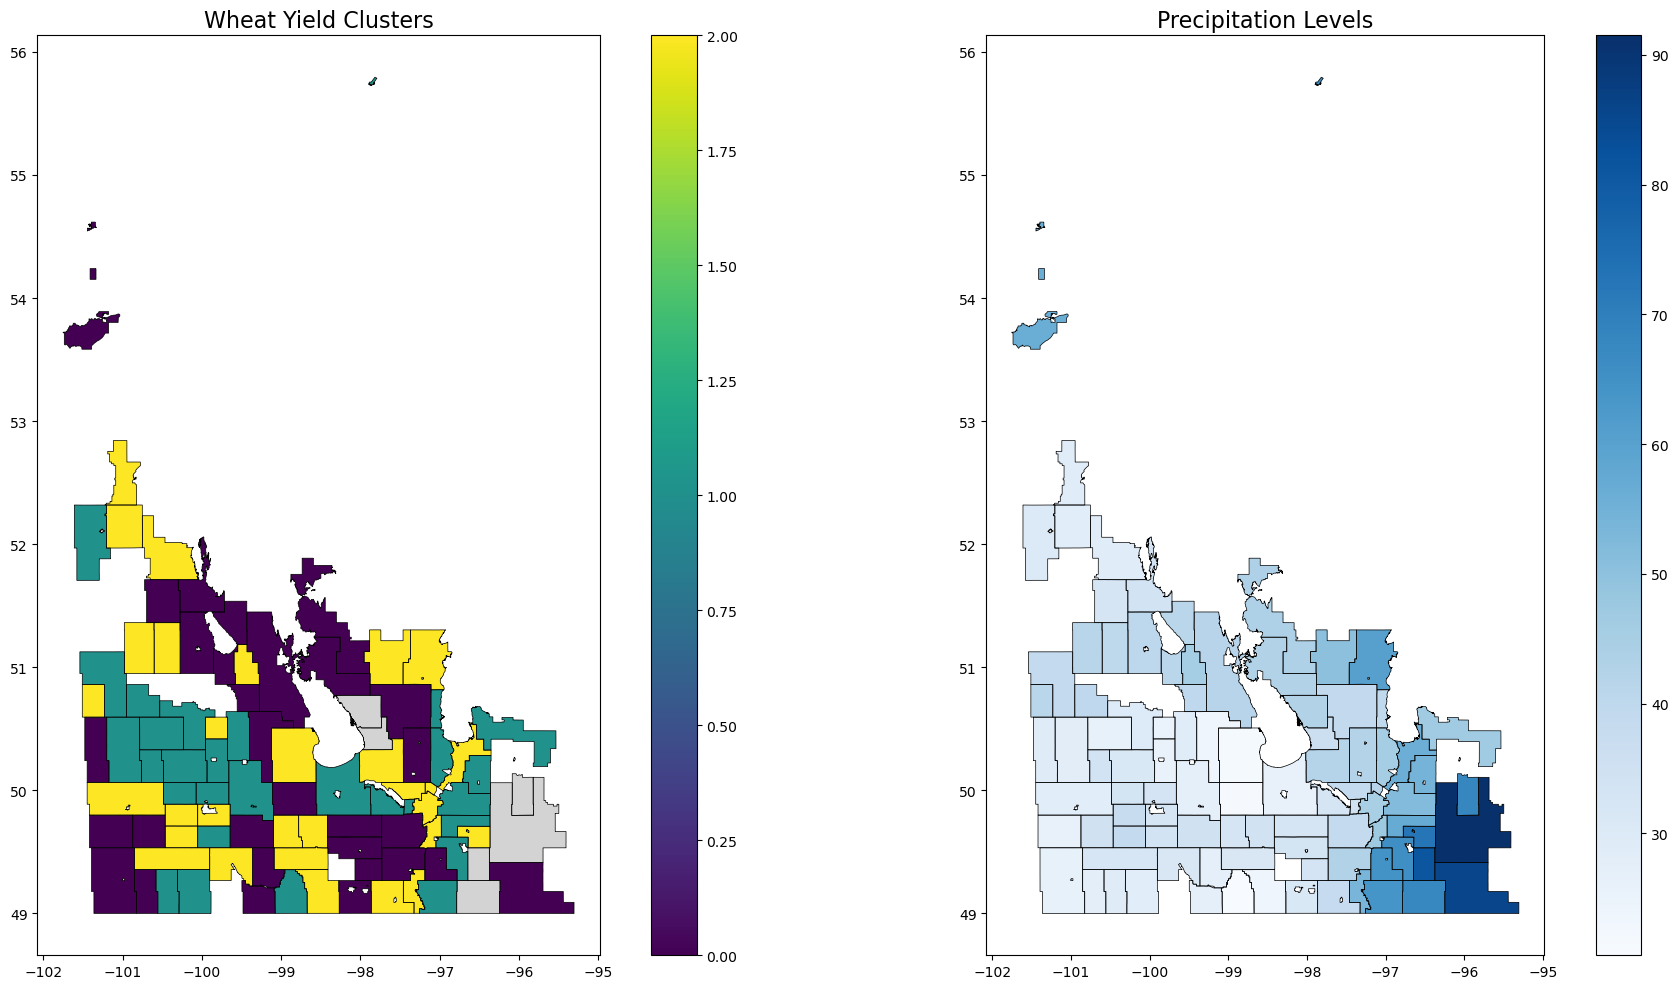

In [73]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot wheat clusters
gdf_wheat_clusters.boundary.plot(ax=axes[0], color="k", linewidth=0.5)
gdf_wheat_clusters.plot(column='Cluster', cmap='viridis', legend=True,
                        ax=axes[0], missing_kwds={'color': 'lightgrey'})
axes[0].set_title("Wheat Yield Clusters", fontsize=16)

# Plot precipitation
gdf_precip.boundary.plot(ax=axes[1], color="k", linewidth=0.5)
gdf_precip.plot(column='Precipitation', cmap='Blues', legend=True,
                ax=axes[1], missing_kwds={'color': 'lightgrey'})
axes[1].set_title("Precipitation Levels", fontsize=16)

plt.tight_layout()
plt.show()

Creating a TOPSIS score between wheat production and precipitation

In [74]:
import pandas as pd
import numpy as np

# Step 1: Filter wheat data and merge with precipitation
df_wheat = df_yield2023[df_yield2023['Crop'] == 'RED SPRING WHEAT']
df_topsis = df_wheat.merge(df_precipfinal, on=['Matched_RM', 'Year'], how='inner')


In [75]:
# Step 2: Normalize wheat yield and precipitation columns
df_topsis['Yield_norm'] = (df_topsis['Weighted_Avg_Yield'] - df_topsis['Weighted_Avg_Yield'].min()) / \
                          (df_topsis['Weighted_Avg_Yield'].max() - df_topsis['Weighted_Avg_Yield'].min())
df_topsis['Precip_norm'] = (df_topsis['Precipitation'] - df_topsis['Precipitation'].min()) / \
                           (df_topsis['Precipitation'].max() - df_topsis['Precipitation'].min())


In [76]:
# Step 3: Assign weights (e.g., 0.7 for yield, 0.3 for precipitation)
weights = np.array([0.7, 0.3])
df_topsis['Yield_weighted'] = df_topsis['Yield_norm'] * weights[0]
df_topsis['Precip_weighted'] = df_topsis['Precip_norm'] * weights[1]

In [77]:
# Step 4: Determine ideal and negative-ideal solutions
ideal_solution = [df_topsis['Yield_weighted'].max(), df_topsis['Precip_weighted'].max()]
negative_ideal_solution = [df_topsis['Yield_weighted'].min(), df_topsis['Precip_weighted'].min()]

# Step 5: Calculate Euclidean distances to the ideal and negative-ideal solutions
df_topsis['Distance_to_Ideal'] = np.sqrt((df_topsis['Yield_weighted'] - ideal_solution[0]) ** 2 + 
                                         (df_topsis['Precip_weighted'] - ideal_solution[1]) ** 2)
df_topsis['Distance_to_Negative_Ideal'] = np.sqrt((df_topsis['Yield_weighted'] - negative_ideal_solution[0]) ** 2 + 
                                                  (df_topsis['Precip_weighted'] - negative_ideal_solution[1]) ** 2)

In [78]:
# Step 6: Calculate TOPSIS score
df_topsis['TOPSIS_Score'] = df_topsis['Distance_to_Negative_Ideal'] / \
                            (df_topsis['Distance_to_Ideal'] + df_topsis['Distance_to_Negative_Ideal'])

# Display the result sorted by TOPSIS score
df_topsis = df_topsis[['Matched_RM', 'Year', 'Weighted_Avg_Yield', 'Precipitation', 'TOPSIS_Score']]
df_topsis.sort_values(by='TOPSIS_Score', ascending=False, inplace=True)
print(df_topsis)

          Matched_RM  Year  Weighted_Avg_Yield  Precipitation  TOPSIS_Score
0          ALEXANDER  2023           84.200000      46.406015      0.796635
18  EMERSON-FRANKLIN  2023           70.650730      64.000000      0.761543
76          THOMPSON  2023           66.963413      67.000000      0.721152
68       SPRINGFIELD  2023           69.919870      52.032609      0.714124
17             ELTON  2023           77.599259      33.125000      0.712530
..               ...   ...                 ...            ...           ...
33            KELSEY  2023           41.989444      56.162162      0.360165
42            MORRIS  2023           40.876649      43.011236      0.309920
66            SIFTON  2023           40.666000      34.683333      0.288002
43      MOSSEY RIVER  2023           30.721937      34.131868      0.152269
80    WEST INTERLAKE  2023           22.000000      42.924658      0.123767

[87 rows x 5 columns]


In [102]:
# Rename the 'Weighted_Avg_Yield' column to 'Weighted_Avg_Wheat_Yield'
df_topsis.rename(columns={'Wheat_Yield': 'Weighted_Avg_Wheat_Yield'}, inplace=True)

# Step to create the rank column based on TOPSIS Score
df_topsis['Rank'] = df_topsis['TOPSIS_Score'].rank(ascending=False)

# Export the DataFrame to a CSV file
df_topsis.to_csv('wheat_yield_topsis_scores.csv', index=False)

print(df_topsis)

          Matched_RM  Year  Weighted_Avg_Wheat_Yield  Precipitation  \
0          ALEXANDER  2023                 84.200000      46.406015   
18  EMERSON-FRANKLIN  2023                 70.650730      64.000000   
76          THOMPSON  2023                 66.963413      67.000000   
68       SPRINGFIELD  2023                 69.919870      52.032609   
17             ELTON  2023                 77.599259      33.125000   
..               ...   ...                       ...            ...   
33            KELSEY  2023                 41.989444      56.162162   
42            MORRIS  2023                 40.876649      43.011236   
66            SIFTON  2023                 40.666000      34.683333   
43      MOSSEY RIVER  2023                 30.721937      34.131868   
80    WEST INTERLAKE  2023                 22.000000      42.924658   

    TOPSIS_Score  Rank  
0       0.796635   1.0  
18      0.761543   2.0  
76      0.721152   3.0  
68      0.714124   4.0  
17      0.712530   5.0

In [103]:
# Selecting only the desired columns
df_topsis_filtered = df_topsis[['Matched_RM', 'TOPSIS_Score', 'Rank']]

# Display the filtered DataFrame
print(df_topsis_filtered)


          Matched_RM  TOPSIS_Score  Rank
0          ALEXANDER      0.796635   1.0
18  EMERSON-FRANKLIN      0.761543   2.0
76          THOMPSON      0.721152   3.0
68       SPRINGFIELD      0.714124   4.0
17             ELTON      0.712530   5.0
..               ...           ...   ...
33            KELSEY      0.360165  83.0
42            MORRIS      0.309920  84.0
66            SIFTON      0.288002  85.0
43      MOSSEY RIVER      0.152269  86.0
80    WEST INTERLAKE      0.123767  87.0

[87 rows x 3 columns]


Spectral Clustering and TOPSIS score for Barley

/var/folders/6p/pp8cz3090vl4_grtyrm2_w_80000gn/T/ipykernel_75285/2351741146.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barley['Cluster'] = spectral.fit_predict(X)


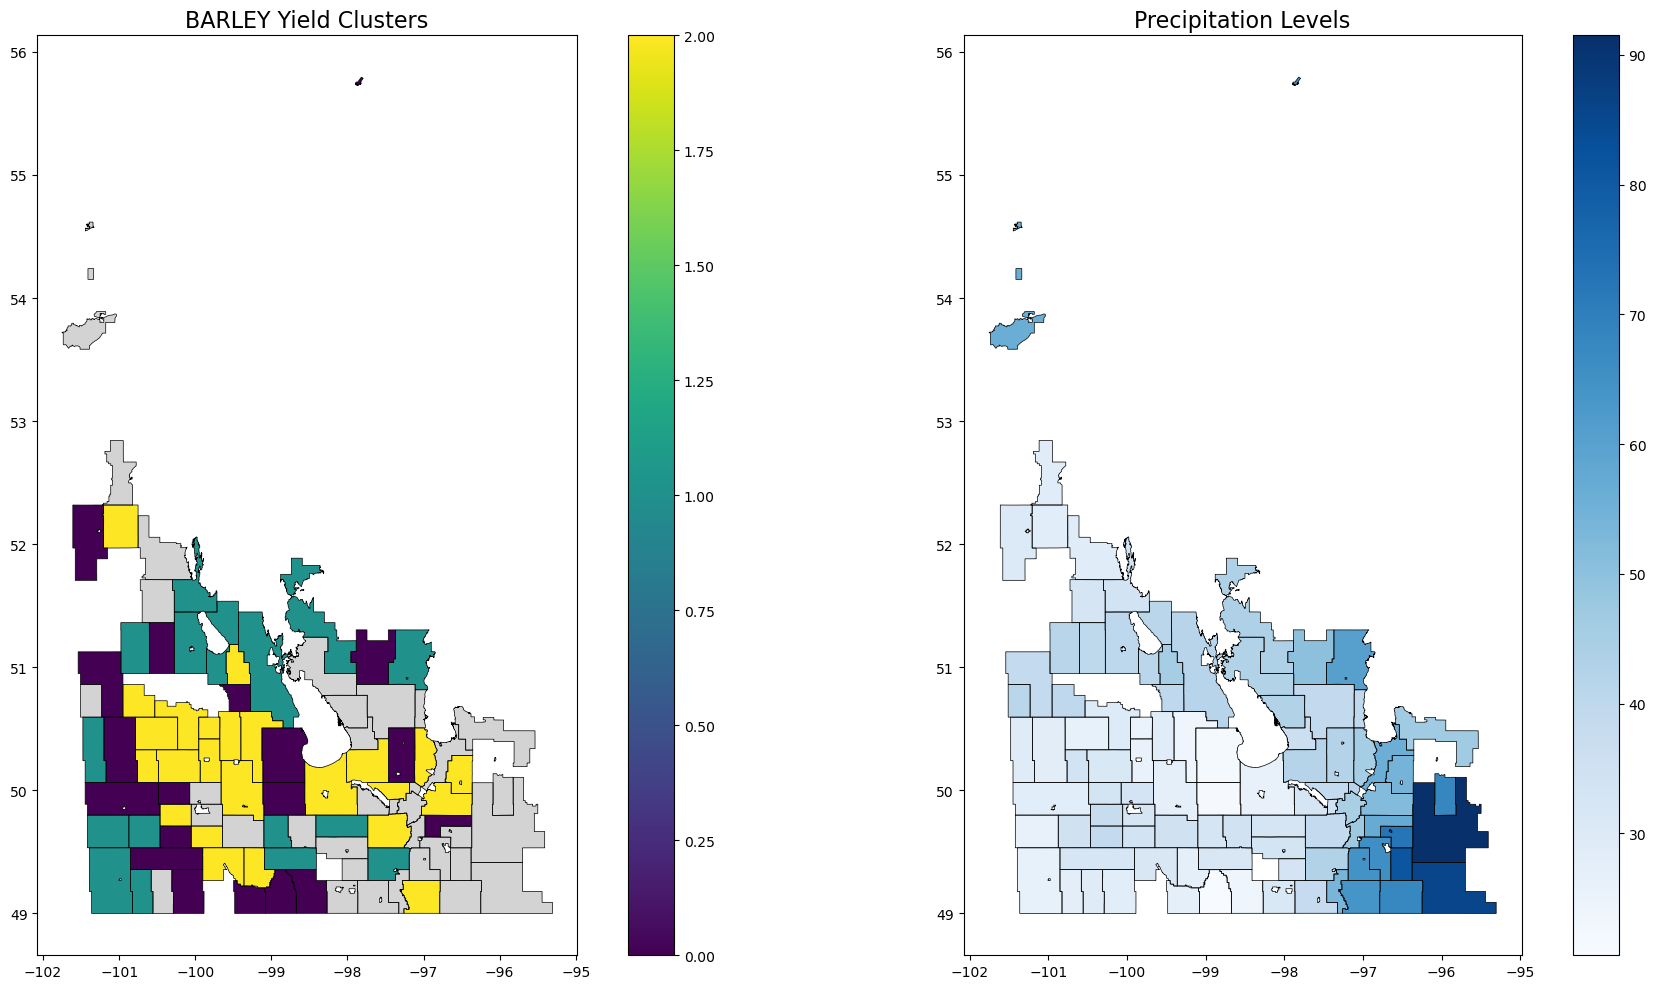

In [84]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.cluster import SpectralClustering

# Filter for wheat data and cluster
df_barley = df_yield2023[df_yield2023['Crop'] == 'BARLEY']
X = df_barley[['Weighted_Avg_Yield']].copy()
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
df_barley['Cluster'] = spectral.fit_predict(X)

# Merge wheat data with precipitation
df_merged2 = df_barley[['Matched_RM', 'Weighted_Avg_Yield', 'Cluster']].merge(
    df_precipfinal[['Matched_RM', 'Precipitation']], on='Matched_RM', how='inner'
)

# Load geospatial data for plotting (assuming gdf_rm contains geometries for Matched_RM)
gdf_barley_clusters = gdf_rm.merge(df_merged2[['Matched_RM', 'Cluster']], on='Matched_RM', how='left')
gdf_precip = gdf_rm.merge(df_precipfinal[['Matched_RM', 'Precipitation']], on='Matched_RM', how='left')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot wheat clusters
gdf_barley_clusters.boundary.plot(ax=axes[0], color="k", linewidth=0.5)
gdf_barley_clusters.plot(column='Cluster', cmap='viridis', legend=True,
                        ax=axes[0], missing_kwds={'color': 'lightgrey'})
axes[0].set_title("BARLEY Yield Clusters", fontsize=16)

# Plot precipitation
gdf_precip.boundary.plot(ax=axes[1], color="k", linewidth=0.5)
gdf_precip.plot(column='Precipitation', cmap='Blues', legend=True,
                ax=axes[1], missing_kwds={'color': 'lightgrey'})
axes[1].set_title("Precipitation Levels", fontsize=16)

plt.tight_layout()
plt.show()


In [87]:
df_barley2 = df_yield2023[df_yield2023['Crop'] == 'BARLEY'].copy()
print(df_barley2)

                  Matched_RM    Crop  Year  Weighted_Avg_Yield
94                    ALONSA  BARLEY  2023           54.400000
168                   ARGYLE  BARLEY  2023           87.279602
273         BIFROST-RIVERTON  BARLEY  2023           65.363024
367        BOISSEVAIN-MORTON  BARLEY  2023           82.363802
461           BRENDA-WASKADA  BARLEY  2023           57.920656
553               BROKENHEAD  BARLEY  2023          116.000000
719        CARTWRIGHT-ROBLIN  BARLEY  2023           78.632624
800     CLANWILLIAM-ERICKSON  BARLEY  2023           86.000000
937                  DAUPHIN  BARLEY  2023           67.900000
1249           ELLICE-ARCHIE  BARLEY  2023           38.000000
1417        EMERSON-FRANKLIN  BARLEY  2023          105.500000
1549                  FISHER  BARLEY  2023           72.965729
1631          GILBERT PLAINS  BARLEY  2023           79.100000
1845      GLENELLA-LANSDOWNE  BARLEY  2023           86.789599
1906              GRAHAMDALE  BARLEY  2023            7

In [88]:
df_barley_precip = pd.merge(df_barley2, df_precipfinal, on=['Matched_RM', 'Year'])


In [89]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_barley_precip[['Yield_Scaled', 'Precip_Scaled']] = scaler.fit_transform(df_barley_precip[['Weighted_Avg_Yield', 'Precipitation']])


In [90]:
import numpy as np

# Define ideal best and worst
ideal_best = df_barley_precip[['Yield_Scaled', 'Precip_Scaled']].max()
ideal_worst = df_barley_precip[['Yield_Scaled', 'Precip_Scaled']].min()

# Compute the Euclidean distances
df_barley_precip['D_pos'] = np.sqrt(((df_barley_precip[['Yield_Scaled', 'Precip_Scaled']] - ideal_best) ** 2).sum(axis=1))
df_barley_precip['D_neg'] = np.sqrt(((df_barley_precip[['Yield_Scaled', 'Precip_Scaled']] - ideal_worst) ** 2).sum(axis=1))

# Calculate the TOPSIS score
df_barley_precip['TOPSIS_Score'] = df_barley_precip['D_neg'] / (df_barley_precip['D_pos'] + df_barley_precip['D_neg'])


In [97]:
df_barley_precip['Rank'] = df_barley_precip['TOPSIS_Score'].rank(ascending=False)
df_barley_precip = df_barley_precip.sort_values(by='TOPSIS_Score', ascending=False)

# Store in a new DataFrame
topsis_barley_df = df_barley_precip[['Matched_RM', 'TOPSIS_Score', 'Rank', 'Weighted_Avg_Yield', 'Precipitation']]

# Export to CSV
topsis_barley_df.to_csv('Barley_TOPSIS_Scores.csv', index=False)

# Display in VS Code
topsis_barley_df


,Matched_RM,TOPSIS_Score,Rank,Weighted_Avg_Yield,Precipitation
10,EMERSON-FRANKLIN,0.903453,1.0,105.500000,64.000000
5,BROKENHEAD,0.815209,2.0,116.000000,54.293103
46,SPRINGFIELD,0.789191,3.0,119.000000,52.032609
51,THOMPSON,0.784454,4.0,82.100000,67.000000
50,TACHE,0.730117,5.0,83.600000,56.950000
2,BIFROST-RIVERTON,0.666219,6.0,65.363024,60.325758
47,ST. ANDREWS,0.656949,7.0,96.600000,45.590164
48,STE. ROSE,0.631197,8.0,88.800000,45.791667
11,FISHER,0.615096,9.0,72.965729,50.459016
42,ROSSBURN,0.589124,10.0,95.274895,39.921875
